# LSTM for IDS


## Imports

In [2]:
import torch
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch.utils import data as data_utils
from torch import nn  # All neural network modules
from torch.utils.data import (
    DataLoader,
)  # Gives easier dataset managment by creating mini batches etc.
from tqdm import tqdm  # For a nice progress bar!

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import tensorflow as tf

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt 


#from scipy.io import arff

## Data Preprocessing CICIDS2017

In [3]:
mon = pd.read_csv("Monday-WorkingHours.pcap_ISCX.csv", encoding="utf-8")
tues = pd.read_csv("Tuesday-WorkingHours.pcap_ISCX.csv", encoding="utf-8")
wed = pd.read_csv("Wednesday-workingHours.pcap_ISCX.csv", encoding="utf-8")
thur_web = pd.read_csv("Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv", encoding="utf-8")
thur_inf = pd.read_csv("Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv", encoding="utf-8")
frid_ddos = pd.read_csv("Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv", encoding="utf-8")
frid_port = pd.read_csv("Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv", encoding="utf-8")
frid_morn = pd.read_csv("Friday-WorkingHours-Morning.pcap_ISCX.csv", encoding="utf-8")

FileNotFoundError: [Errno 2] No such file or directory: 'Monday-WorkingHours.pcap_ISCX.csv'

In [54]:
## global pyplot settings -- can be changed for a specific instance
plt.rcParams['figure.figsize'] = (8, 5.28) 
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["axes.titlesize"] = 13
plt.rcParams["axes.titleweight"] = 600

sns.set_color_codes("pastel")

In [55]:
### all labels are of numerical type, despite Label column
mon.info()  # same format applies to other files

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 529918 entries, 0 to 529917
Data columns (total 79 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0    Destination Port             529918 non-null  int64  
 1    Flow Duration                529918 non-null  int64  
 2    Total Fwd Packets            529918 non-null  int64  
 3    Total Backward Packets       529918 non-null  int64  
 4   Total Length of Fwd Packets   529918 non-null  int64  
 5    Total Length of Bwd Packets  529918 non-null  int64  
 6    Fwd Packet Length Max        529918 non-null  int64  
 7    Fwd Packet Length Min        529918 non-null  int64  
 8    Fwd Packet Length Mean       529918 non-null  float64
 9    Fwd Packet Length Std        529918 non-null  float64
 10  Bwd Packet Length Max         529918 non-null  int64  
 11   Bwd Packet Length Min        529918 non-null  int64  
 12   Bwd Packet Length Mean       529918 non-nul

In [56]:
#searching for NA values - empty "" are not considered NA - but that is of no concern in this dataset 
pd.options.mode.use_inf_as_na = True ## so that inf is also treated as NA value
print("mon NA values")
print(mon.loc[:, mon.isnull().any()].isnull().sum())
print("=====================")
print("tues NA values")
print(tues.loc[:, tues.isnull().any()].isnull().sum())
print("=====================")
print("wed NA values")
print(wed.loc[:, wed.isnull().any()].isnull().sum())
print("=====================")
print("thur NA values")
print(thur_web.loc[:, thur_web.isnull().any()].isnull().sum())
print("=====================")
print(thur_inf.loc[:, thur_inf.isnull().any()].isnull().sum())
print("=====================")
print("Friday NA values")
print(frid_ddos.loc[:, frid_ddos.isnull().any()].isnull().sum())
print("=====================")
print(frid_port.loc[:, frid_port.isnull().any()].isnull().sum())
print("=====================")
print(frid_morn.loc[:, frid_morn.isnull().any()].isnull().sum())

mon NA values
Flow Bytes/s       437
 Flow Packets/s    437
dtype: int64
tues NA values
Flow Bytes/s       264
 Flow Packets/s    264
dtype: int64
wed NA values
Flow Bytes/s       1297
 Flow Packets/s    1297
dtype: int64
thur NA values
Flow Bytes/s       135
 Flow Packets/s    135
dtype: int64
Flow Bytes/s       207
 Flow Packets/s    207
dtype: int64
Friday NA values
Flow Bytes/s       34
 Flow Packets/s    34
dtype: int64
Flow Bytes/s       371
 Flow Packets/s    371
dtype: int64
Flow Bytes/s       122
 Flow Packets/s    122
dtype: int64


In [57]:
### NA values are minority of the dataset. Because they cannot be processed by algorithms, they can be easily discarded 
mon = mon.dropna()
tues = tues.dropna()
wed = wed.dropna()
thur_web = thur_web.dropna()
thur_inf = thur_inf.dropna()
frid_ddos = frid_ddos.dropna()
frid_port = frid_port.dropna()
frid_morn = frid_morn.dropna()

In [58]:
## join all data into one DataFrame
all_data = pd.concat([mon, tues, wed, thur_web, thur_inf, frid_ddos, frid_port, frid_morn], ignore_index=True)

all_data

Destination Port   Flow Duration   Total Fwd Packets  \
0                    49188               4                   2   
1                    49188               1                   2   
2                    49188               1                   2   
3                    49188               1                   2   
4                    49486               3                   2   
...                    ...             ...                 ...   
2827871                 53           61452                   4   
2827872                 53             171                   2   
2827873                 53             222                   2   
2827874                123           16842                   1   
2827875                 53             153                   2   

          Total Backward Packets  Total Length of Fwd Packets  \
0                              0                           12   
1                              0                           12   
2                              0                           12   
3                              0                           12   
4                              0                           12   
...                          ...                          ...   
2827871                        2                          180   
2827872                        2                           80   
2827873                        2                           90   
2827874                        1                           48   
2827875                        2                           68   

          Total Length of Bwd Packets   Fwd Packet Length Max  \
0                                   0                       6   
1                                   0                       6   
2                                   0                       6   
3                                   0                       6   
4                                   0                       6   
...                               ...                     ...   
2827871                           354                      45   
2827872                           272                      40   
2827873                           354                      45   
2827874                            48                      48   
2827875                           100                      34   

          Fwd Packet Length Min   Fwd Packet Length Mean  \
0                             6                      6.0   
1                             6                      6.0   
2                             6                      6.0   
3                             6                      6.0   
4                             6                      6.0   
...                         ...                      ...   
2827871                      45                     45.0   
2827872                      40                     40.0   
2827873                      45                     45.0   
2827874                      48                     48.0   
2827875                      34                     34.0   

          Fwd Packet Length Std  ...   min_seg_size_forward  Active Mean  \
0                           0.0  ...                     20          0.0   
1                           0.0  ...                     20          0.0   
2                           0.0  ...                     20          0.0   
3                           0.0  ...                     20          0.0   
4                           0.0  ...                     20          0.0   
...                         ...  ...                    ...          ...   
2827871                     0.0  ...                     20          0.0   
2827872                     0.0  ...                     32          0.0   
2827873                     0.0  ...                     32          0.0   
2827874                     0.0  ...                     20          0.0   
2827875                     0.0  ...                     20          0.0   

          Active Std 

In [59]:
## feature selection phase - find cols w/ all zero values 

#all_datav2.describe().iloc[1:].apply(np.sum, index=[])
describe_info = all_data.describe()
all_zeroes_cols = describe_info.loc[:,(describe_info.iloc[1:] == 0).all()]
all_zeroes_cols



Bwd PSH Flags   Bwd URG Flags  Fwd Avg Bytes/Bulk  \
count       2827876.0       2827876.0           2827876.0   
mean              0.0             0.0                 0.0   
std               0.0             0.0                 0.0   
min               0.0             0.0                 0.0   
25%               0.0             0.0                 0.0   
50%               0.0             0.0                 0.0   
75%               0.0             0.0                 0.0   
max               0.0             0.0                 0.0   

        Fwd Avg Packets/Bulk   Fwd Avg Bulk Rate   Bwd Avg Bytes/Bulk  \
count              2827876.0           2827876.0            2827876.0   
mean                     0.0                 0.0                  0.0   
std                      0.0                 0.0                  0.0   
min                      0.0                 0.0                  0.0   
25%                      0.0                 0.0                  0.0   
50%                      0.0                 0.0                  0.0   
75%                      0.0                 0.0                  0.0   
max                      0.0                 0.0                  0.0   

        Bwd Avg Packets/Bulk  Bwd Avg Bulk Rate  
count              2827876.0          2827876.0  
mean                     0.0                0.0  
std                      0.0                0.0  
min                      0.0                0.0  
25%                      0.0                0.0  
50%                      0.0                0.0  
75%                      0.0                0.0  
max                      0.0                0.0

In [60]:
## removing [8] features 
all_data.drop(columns=all_zeroes_cols, inplace=True)

all_data.shape # check if resulting DataFrame valid

(2827876, 71)

In [61]:
print("Before...")
print(all_data.loc[:," Label"].unique())

all_data.loc[:," Label"].replace({"Web Attack � XSS" : "XSS", "Web Attack � Sql Injection": "Sql Injection", "Web Attack � Brute Force": "Brute Force"}, inplace=True)
print("After..")
print(all_data.loc[:," Label"].unique())

## remove trailing && leading spaces from all the labels
rename_cols = lambda col_lbl: col_lbl.strip()
all_data.rename(rename_cols, axis=1, inplace=True, errors="raise")

Before...
['BENIGN' 'FTP-Patator' 'SSH-Patator' 'DoS slowloris' 'DoS Slowhttptest'
 'DoS Hulk' 'DoS GoldenEye' 'Heartbleed' 'Web Attack � Brute Force'
 'Web Attack � XSS' 'Web Attack � Sql Injection' 'Infiltration' 'DDoS'
 'PortScan' 'Bot']
After..
['BENIGN' 'FTP-Patator' 'SSH-Patator' 'DoS slowloris' 'DoS Slowhttptest'
 'DoS Hulk' 'DoS GoldenEye' 'Heartbleed' 'Brute Force' 'XSS'
 'Sql Injection' 'Infiltration' 'DDoS' 'PortScan' 'Bot']


In [62]:
trf_type = all_data.loc[:, "Label"].map(lambda lbl: "Normal" if lbl == "BENIGN" else "Attack")
trf_type.name = "traffic type"
all_data.loc[:, trf_type.name] = trf_type

#all_data
print(all_data.shape)

(2827876, 72)


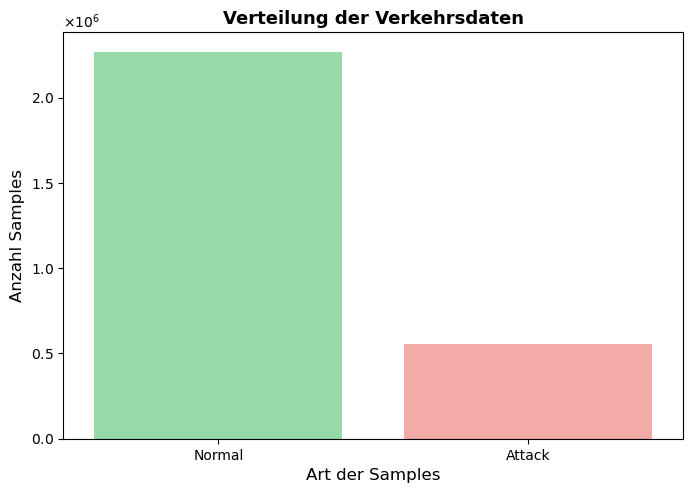

In [63]:
### plot distrtibution of Normal traffic and Attacks in the whole dataset 

#from matplotlib.ticker import StrMethodFormatter, MultipleLocator
#fmt = StrMethodFormatter("{x:,}")  #below lines are just another approach on formatting yaxis
#ax = plt.gca()
#locator = MultipleLocator(1*10**5)
#ax.yaxis.set_major_locator(locator)
#ax.yaxis.set_major_formatter(fmt)
plt.ticklabel_format(axis='y', useMathText=True, useOffset=False)  # change def ScalarFormatter

sns.countplot(x="traffic type", data=all_data, palette=["g","r"])
#plt.title("Traffic type distribution in whole dataset")
plt.title("Verteilung der Verkehrsdaten")
plt.xlabel("Art der Samples")
plt.ylabel("Anzahl Samples")
plt.savefig("distribution1.png", dpi=200, format='png')
plt.show()



In [64]:
### Normal traffic greatly outweights Evil traffic. To avoid for the model to be biased towards one type of traffic, it has to be downsampled
all_data.loc[:, "traffic type"].value_counts()

## DOWNSAMPLING
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=10, sampling_strategy=0.85) # equals traffic unless ratio is specified


all_data.drop(["traffic type"], axis=1, inplace=True) # temporarily rm the categorical column for underSampling

all_data_res, trf_type_res = rus.fit_resample(all_data, trf_type) #rus.sample

#all_datav2 = pd.concat([all_data_res, trf_type_res], join="inner")  # another way to join dataframe w/ series
all_datav2 = all_data_res.join(trf_type_res, how="inner")

all_datav2.shape # check if resulting DaraFrame valid

(1211327, 72)

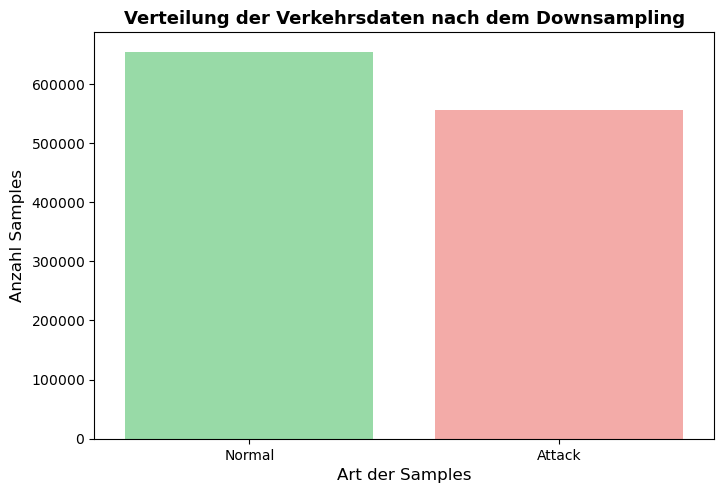

In [65]:
### show distribution chart after downsampling huge Normal traffic 

plt.ticklabel_format(axis='y', useMathText=True, useOffset=False)  # change def ScalarFormatter
sns.countplot(x="traffic type", data=all_datav2, order=["Normal", "Attack"],  palette=["g","r"])

#plt.title("Traffic type distribution in whole dataset after random downsampling")
plt.title("Verteilung der Verkehrsdaten nach dem Downsampling")
plt.xlabel("Art der Samples")
plt.ylabel("Anzahl Samples")
plt.savefig("distribution1.png", dpi=200, format='png')
plt.show()

In [66]:
## feature selection phase - prepare data for RFC
lbls = all_datav2.loc[:, "Label"]
data_w_o_cat_attrs = all_datav2.iloc[:, :-2]



In [67]:
data_w_o_cat_attrs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1211327 entries, 0 to 1211326
Data columns (total 70 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   Destination Port             1211327 non-null  int64  
 1   Flow Duration                1211327 non-null  int64  
 2   Total Fwd Packets            1211327 non-null  int64  
 3   Total Backward Packets       1211327 non-null  int64  
 4   Total Length of Fwd Packets  1211327 non-null  int64  
 5   Total Length of Bwd Packets  1211327 non-null  int64  
 6   Fwd Packet Length Max        1211327 non-null  int64  
 7   Fwd Packet Length Min        1211327 non-null  int64  
 8   Fwd Packet Length Mean       1211327 non-null  float64
 9   Fwd Packet Length Std        1211327 non-null  float64
 10  Bwd Packet Length Max        1211327 non-null  int64  
 11  Bwd Packet Length Min        1211327 non-null  int64  
 12  Bwd Packet Length Mean       1211327 non-n

In [68]:
## feature selection phase - use RFC on data
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=10, n_jobs=-1) # 100 trees in forest

# fit random forest classifier on the dataset
rfc.fit(data_w_o_cat_attrs, lbls)

RandomForestClassifier(n_jobs=-1, random_state=10)

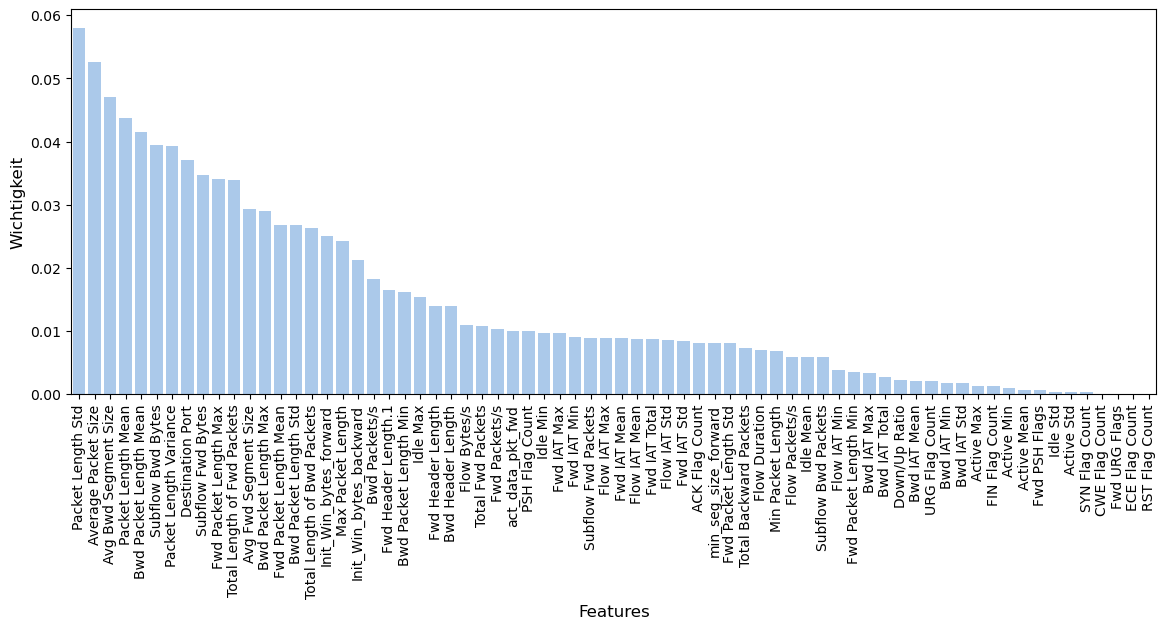

In [69]:
## plotting features' importance in the whole dataset graph

# extract important features
score = np.round(rfc.feature_importances_,5)
importances = pd.DataFrame({'Features':data_w_o_cat_attrs.columns,'Wichtigkeit':score})
importances = importances.sort_values('Wichtigkeit',ascending=False).set_index('Features')

# plot importances
sns.barplot(x=importances.index, y="Wichtigkeit", data=importances, color="b")
plt.xticks(rotation="vertical")
plt.gcf().set_size_inches(14,5)
plt.savefig("importances.png", dpi=200, format='png', bbox_inches = "tight", pad_inches=0.2)
plt.show()

#importances.plot.bar()  # alt way to achieve similar plot

In [70]:
## Selecting most important features 
threshold = 0.001 # importance threshold

#bl_thresh = importances.loc[importances["importance"] < threshold]
bl_thresh = importances.loc[importances["Wichtigkeit"] < threshold]
print("there are {} features to delete, as they are below chosen threshold".format(bl_thresh.shape[0]))
print("these features are the following:")
feats_to_del = [feat for feat in bl_thresh.index]
print("\n".join(feats_to_del))

## removing these not important features 
all_datav2.drop(columns=feats_to_del, inplace=True) # dropping columns

there are 9 features to delete, as they are below chosen threshold
these features are the following:
Active Mean
Fwd PSH Flags
Idle Std
Active Std
SYN Flag Count
CWE Flag Count
Fwd URG Flags
ECE Flag Count
RST Flag Count


In [71]:
all_datav2

Destination Port  Flow Duration  Total Fwd Packets  \
0                      80        5216127                  3   
1                      21             20                  1   
2                      21             38                  1   
3                      21             80                  1   
4                      21             68                  1   
...                   ...            ...                ...   
1211322                53          30889                  2   
1211323               443              3                  2   
1211324                53          72063                  1   
1211325             53402              3                  2   
1211326                53          23808                  1   

         Total Backward Packets  Total Length of Fwd Packets  \
0                             1                            0   
1                             1                            0   
2                             1                            0   
3                             1                            0   
4                             1                            0   
...                         ...                          ...   
1211322                       2                           68   
1211323                       0                           12   
1211324                       1                           44   
1211325                       0                            0   
1211326                       1                           53   

         Total Length of Bwd Packets  Fwd Packet Length Max  \
0                                  0                      0   
1                                  0                      0   
2                                  0                      0   
3                                  0                      0   
4                                  0                      0   
...                              ...                    ...   
1211322                          166                     34   
1211323                            0                      6   
1211324                          184                     44   
1211325                            0                      0   
1211326                          117                     53   

         Fwd Packet Length Min  Fwd Packet Length Mean  Fwd Packet Length Std  \
0                            0                     0.0                    0.0   
1                            0                     0.0                    0.0   
2                            0                     0.0                    0.0   
3                            0                     0.0                    0.0   
4                            0                     0.0                    0.0   
...                        ...                     ...                    ...   
1211322                     34                    34.0                    0.0   
1211323                      6                     6.0                    0.0   
1211324                     44                    44.0                    0.0   
1211325                      0                     0.0                    0.0   
1211326                     53                    53.0                    0.0   

         ...  Init_Win_bytes_backward  act_data_pkt_fwd  min_seg_size_forward  \
0        ...                    28960                 0                    32   
1        ...                      227                 0                    32   
2        ...                      227                 0                    32   
3        ...                      227                 0                    32   
4        ...                      227                 0                    32   
...      ...                      ...               ...                   ...   
1211322  ...                       -1                 1                    20   
1211323  ...                       -1                 1                    20   
1211324  ...            

In [72]:
## feature selection phase - find highly correlated feature pairs 
all_data_corr_mtrx = all_datav2.corr(numeric_only=True)

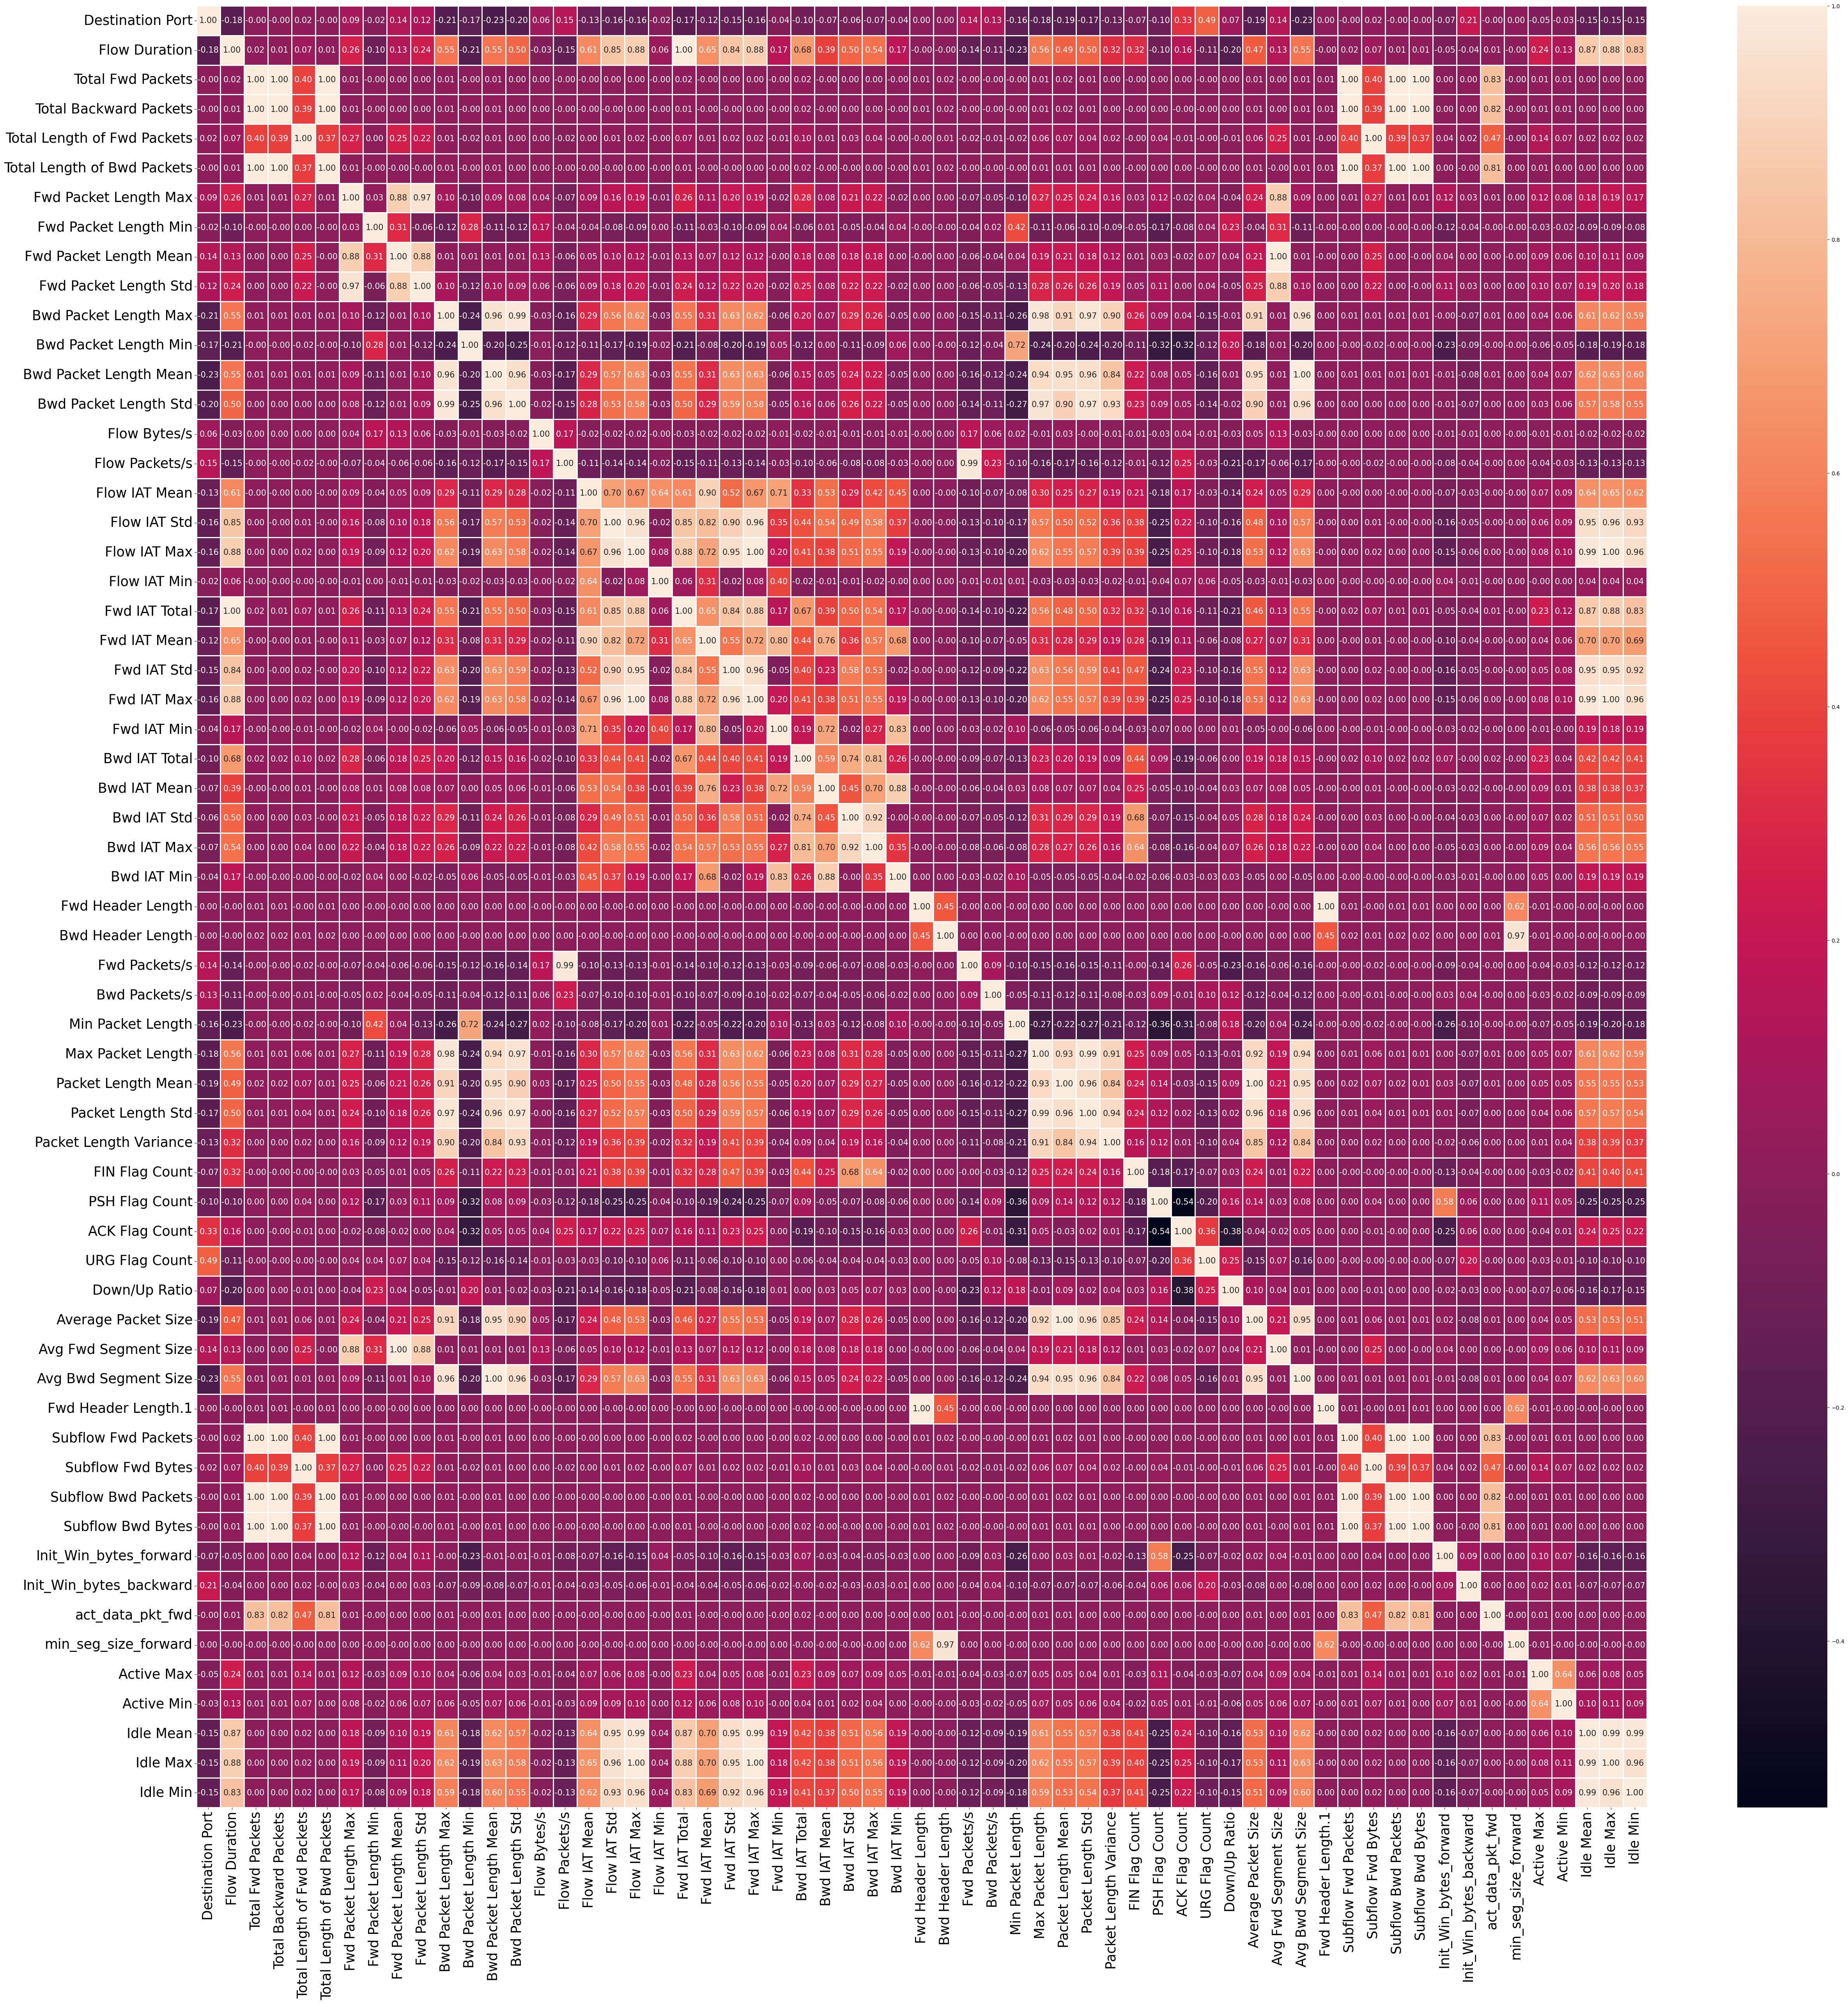

In [73]:
## plotting a correlation heatmap 

plt.gcf().set_size_inches(60, 60)
hm = sns.heatmap(all_data_corr_mtrx, annot=True, linewidths=.8, annot_kws={"fontsize": 15}, fmt=".2f")
hm.set_yticklabels(hm.get_ymajorticklabels(), fontsize = 25)
hm.set_xticklabels(hm.get_xmajorticklabels(), fontsize = 25)
plt.savefig("corr_heatmap.png", dpi=200, format='png', bbox_inches = "tight", pad_inches=0.4)
plt.show()

In [74]:
all_data_corr_mtrx

Destination Port  Flow Duration  \
Destination Port                     1.000000      -0.175034   
Flow Duration                       -0.175034       1.000000   
Total Fwd Packets                   -0.003716       0.016300   
Total Backward Packets              -0.003302       0.014830   
Total Length of Fwd Packets          0.017333       0.070166   
...                                       ...            ...   
Active Max                          -0.045468       0.237431   
Active Min                          -0.028097       0.127197   
Idle Mean                           -0.153371       0.865211   
Idle Max                            -0.152365       0.880098   
Idle Min                            -0.151535       0.833243   

                             Total Fwd Packets  Total Backward Packets  \
Destination Port                     -0.003716               -0.003302   
Flow Duration                         0.016300                0.014830   
Total Fwd Packets                     1.000000                0.998555   
Total Backward Packets                0.998555                1.000000   
Total Length of Fwd Packets           0.395230                0.389193   
...                                        ...                     ...   
Active Max                            0.011977                0.010120   
Active Min                            0.007203                0.007074   
Idle Mean                             0.001438                0.000682   
Idle Max                              0.001545                0.000692   
Idle Min                              0.001288                0.000624   

                             Total Length of Fwd Packets  \
Destination Port                                0.017333   
Flow Duration                                   0.070166   
Total Fwd Packets                               0.395230   
Total Backward Packets                          0.389193   
Total Length of Fwd Packets                     1.000000   
...                                                  ...   
Active Max                                      0.135448   
Active Min                                      0.067069   
Idle Mean                                       0.020135   
Idle Max                                        0.022941   
Idle Min                                        0.016992   

                             Total Length of Bwd Packets  \
Destination Port                               -0.002624   
Flow Duration                                   0.012163   
Total Fwd Packets                               0.997623   
Total Backward Packets                          0.995166   
Total Length of Fwd Packets                     0.373901   
...                                                  ...   
Active Max                                      0.006043   
Active Min                                      0.004722   
Idle Mean                                       0.000649   
Idle Max                                        0.000643   
Idle Min                                        0.000623   

                             Fwd Packet Length Max  Fwd Packet Length Min  \
Destination Port                          0.092711              -0.015019   
Flow Duration                             0.260807              -0.103493   
Total Fwd Packets                         0.008396              -0.002218   
Total Backward Packets                    0.007972              -0.001827   
Total Length of Fwd Packets               0.267650               0.004163   
...                                            ...                    ...   
Active Max                                0.122742              -0.031745   
Active Min                                0.076377              -0.023257   
Idle Mean                                 0.178669              -0.087457   
Idle Max                                  0.187390              -0.089509   
Idle Min                                  0.165355              -0.083693   

    

In [75]:
## process correlation matrix, list highly correlated feature pairs 
def srt_corr(mtrx):
    corr_ustack = mtrx.unstack().abs()
    #corr_ustack
    corr_srted = corr_ustack.sort_values(ascending=False)
    return corr_srted
srt_corr(all_data_corr_mtrx)



Avg Bwd Segment Size    Bwd Packet Length Mean         1.000000e+00
Bwd Packet Length Mean  Avg Bwd Segment Size           1.000000e+00
Destination Port        Destination Port               1.000000e+00
Flow Packets/s          Flow Packets/s                 1.000000e+00
Flow IAT Std            Flow IAT Std                   1.000000e+00
                                                           ...     
Fwd Packet Length Std   Total Length of Bwd Packets    1.934087e-06
Subflow Bwd Bytes       Fwd Packet Length Std          1.649607e-06
Fwd Packet Length Std   Subflow Bwd Bytes              1.649607e-06
min_seg_size_forward    Flow Bytes/s                   5.856477e-07
Flow Bytes/s            min_seg_size_forward           5.856477e-07
Length: 3721, dtype: float64

In [76]:
## process correlation matrix, list highly correlated feature pairs, delete highly correlated features

from collections import OrderedDict
thres_corr = 0.95
epoch=0
highly_corr = {"dummy": "dummy"}
feats_deled = []

all_data_corr_mtrx2 = all_data_corr_mtrx.copy()  # for easy
def add_to_dct(l, ft, ft2):
    try:
        l[ft].append(ft2)
    except KeyError:
        l[ft] = [ft2]

get_imp = lambda feat: importances.loc[feat][0]
srt_key = lambda elem: get_imp(elem[0])  # gets imp of first elem

def what_to_del(dct_srt):    
    to_del = []  #least imp feature
    for k, val in dct_srt.items():
        ## get all indexes lower than current k
        feats_lw_imp = importances[importances.index.slice_indexer(k)].index
        if set(val) - set(feats_lw_imp):  # feat k creates a corr pair w/ feature of higher importance --- delete feat k
            if k not in to_del: to_del.append(k)
        else:  # feat k creates a corr pair w/ features of lower importnace --- delete one w/ lowest imp 
            for ft in feats_lw_imp[::-1]:  # searching from least important
                if ft in val and ft not in to_del:
                    to_del.append(ft)
                    break  ## deleting first founud feat of lowest possible importance
    return to_del
        
            
while highly_corr:
    count = 0
    highly_corr.clear()
    for feats, val in srt_corr(all_data_corr_mtrx2).items():
        if val > thres_corr and feats[0] != feats[1]:
            count += 1
            add_to_dct(highly_corr, feats[0], feats[1])
    if not highly_corr: break  # no more highly corr pairs
    highly_corr_srt = OrderedDict(sorted(highly_corr.items(), key=srt_key))  # sorted based on imp

    to_del = what_to_del(highly_corr_srt)
    feats_deled += to_del
    epoch +=1 # first epoch will be 1 not 0! 
    print("there are {} higly correlated pairs in {} iteration".format(count, epoch))
    all_data_corr_mtrx2.drop(to_del, axis=1, inplace=True)
    all_data_corr_mtrx2.drop(to_del, axis=0, inplace=True)  # need to remove the feat from both cols and index

print("deleting: {} feature".format(len(feats_deled)))
print("finally deleted:\n"+ "\n".join(feats_deled))

there are 114 higly correlated pairs in 1 iteration
deleting: 25 feature
finally deleted:
Subflow Bwd Packets
Idle Mean
Flow Packets/s
Flow Duration
Total Backward Packets
min_seg_size_forward
Fwd Packet Length Std
Fwd IAT Std
Flow IAT Std
Flow IAT Max
Subflow Fwd Packets
Fwd IAT Max
Idle Min
Total Fwd Packets
Fwd Header Length
Max Packet Length
Total Length of Bwd Packets
Bwd Packet Length Std
Fwd Packet Length Mean
Bwd Packet Length Max
Total Length of Fwd Packets
Bwd Packet Length Mean
Packet Length Mean
Avg Bwd Segment Size
Average Packet Size


ValueError: The number of FixedLocator locations (36), usually from a call to set_ticks, does not match the number of labels (61).

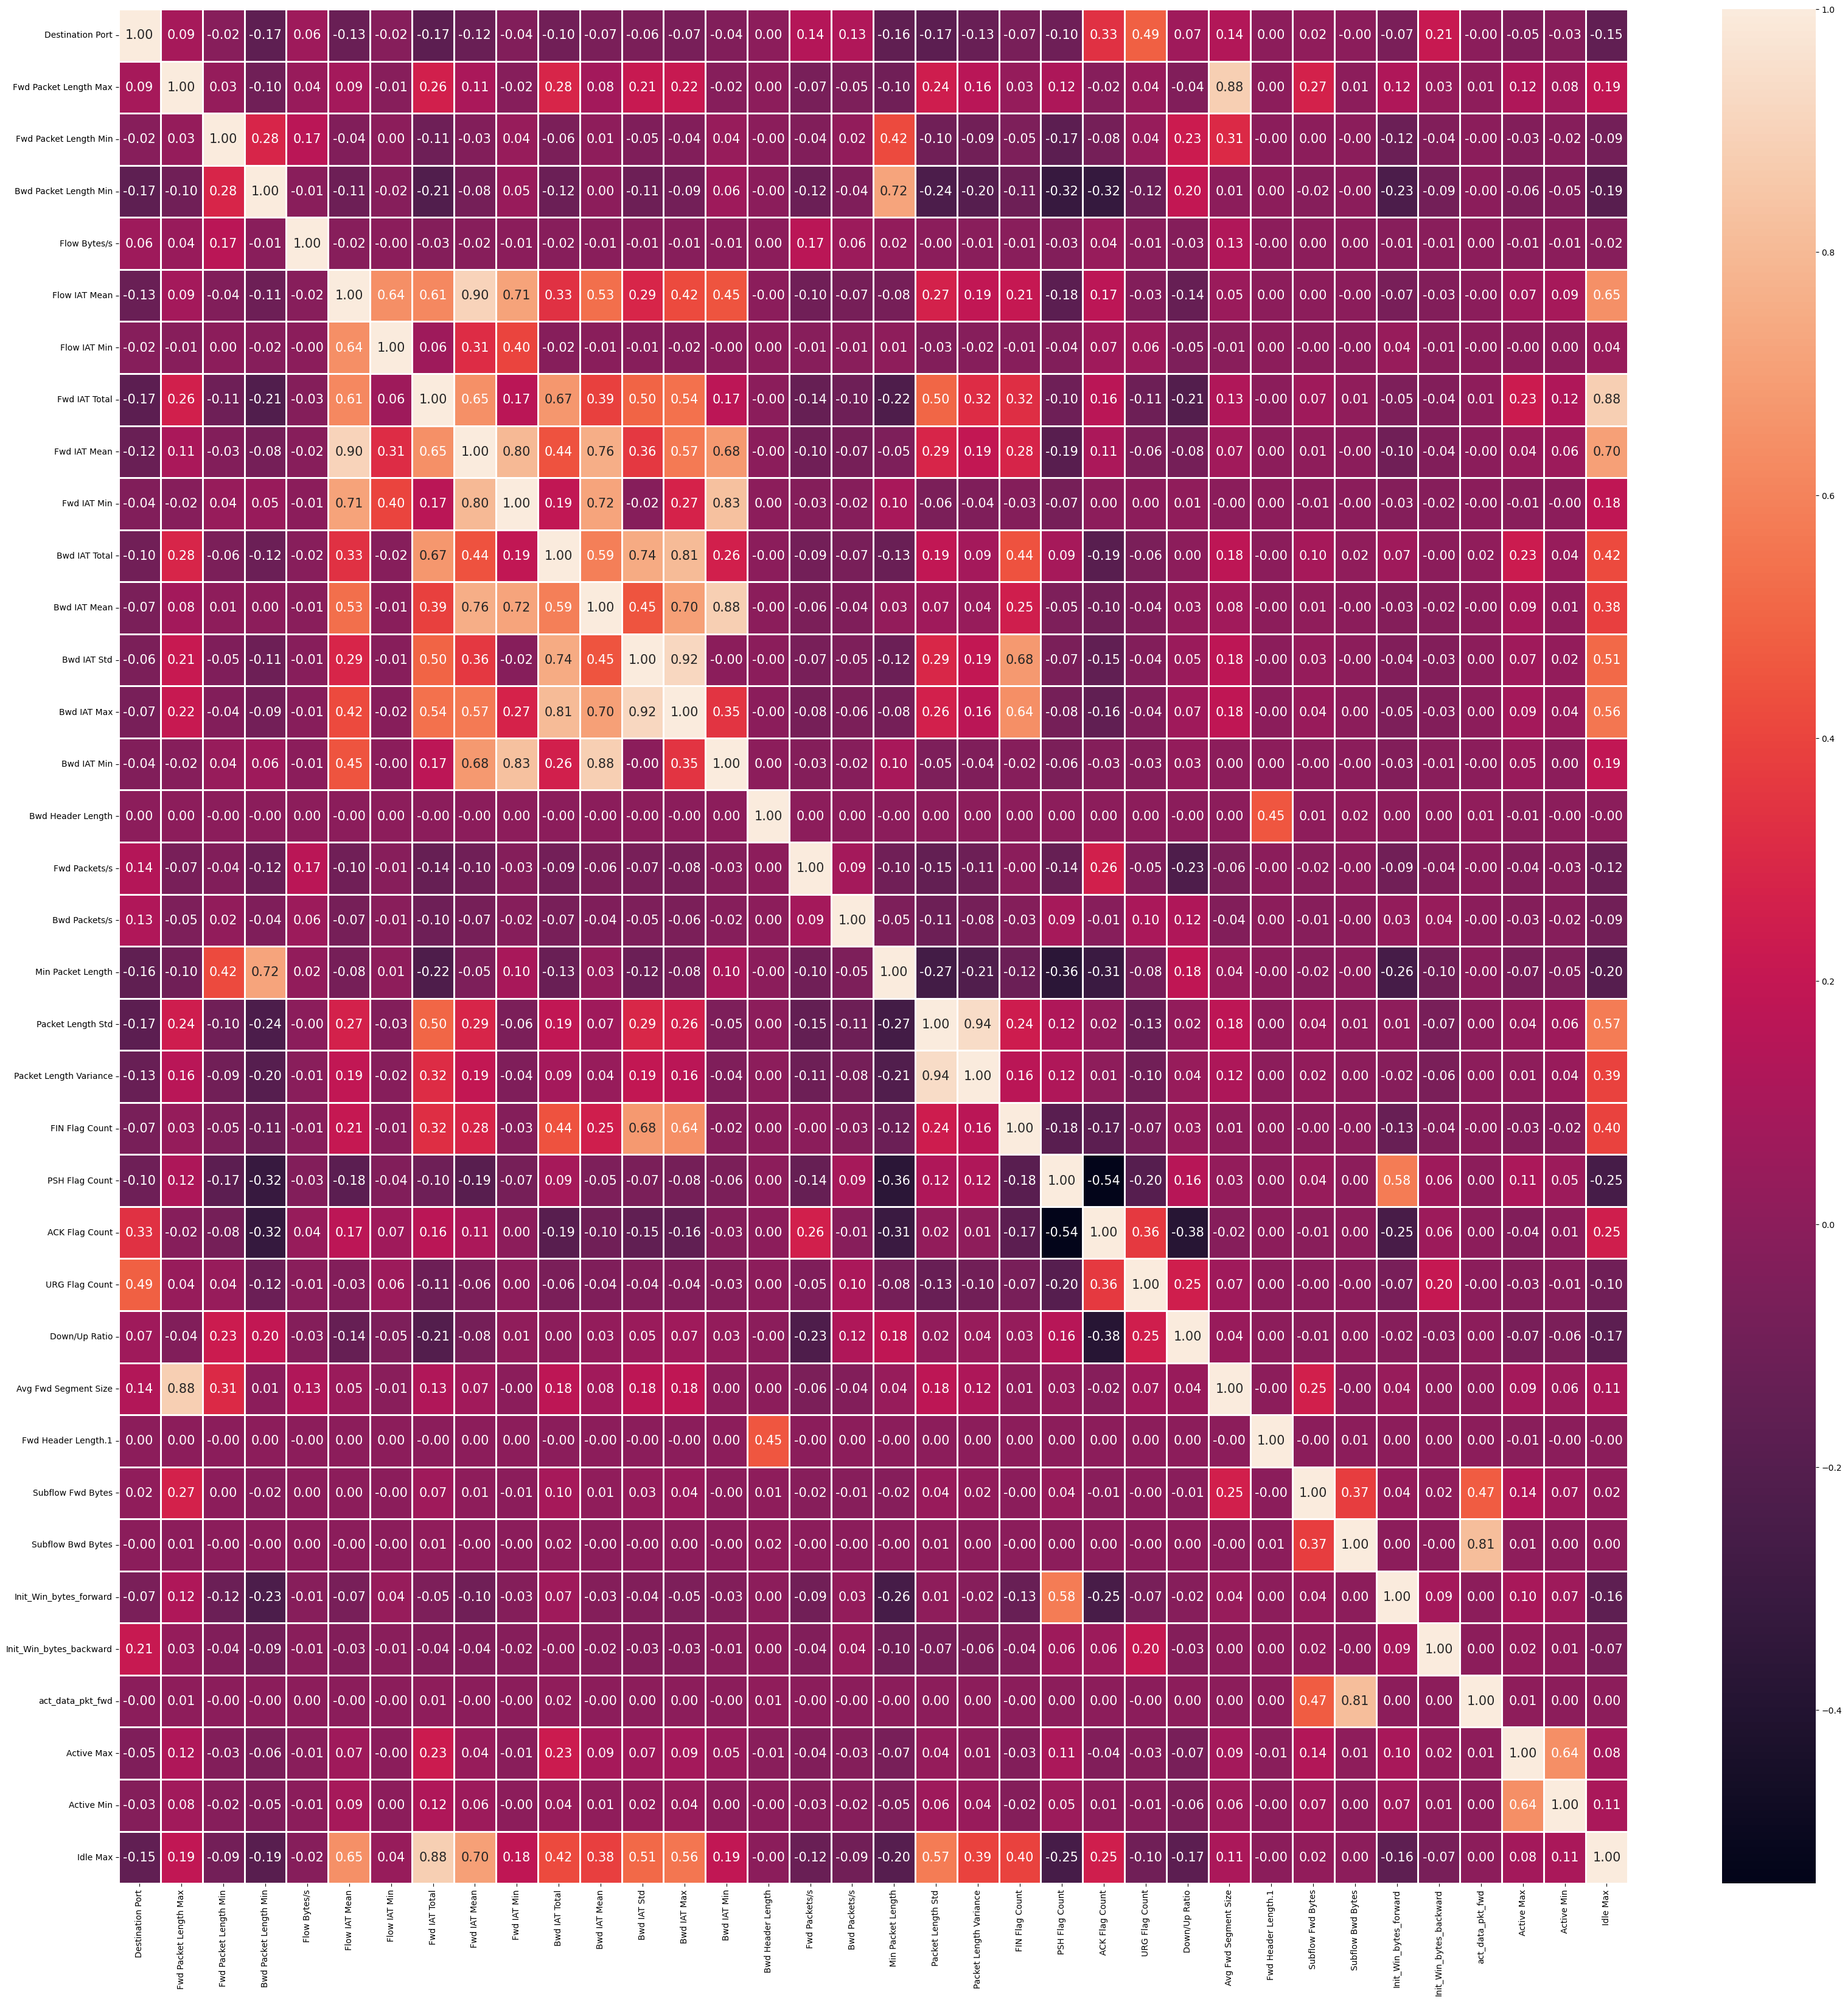

In [77]:
## plotting a correlation heatmap after removing highly correlated pairs

plt.gcf().set_size_inches(40, 40)
hm2 = sns.heatmap(all_data_corr_mtrx2, annot=True, linewidths=.8, annot_kws={"fontsize": 15}, fmt=".2f")
hm2.set_yticklabels(hm.get_ymajorticklabels(), fontsize = 20)
hm2.set_xticklabels(hm.get_xmajorticklabels(), fontsize = 20)
plt.savefig("corr_heatmap2.png", dpi=200, format='png', bbox_inches = "tight", pad_inches=0.4)
plt.show()

In [ ]:
all_datav3 = all_datav2.copy() ## just for ease of cells executing 

all_datav3.drop(feats_deled, axis=1, inplace=True)

all_datav3_cp = all_datav3.copy()

all_datav3 

In [ ]:
# scaling numerical data using Quantile scaling
from sklearn.preprocessing import QuantileTransformer
qt = QuantileTransformer(random_state=10) # number of quantiles can be set, default n_quantiles=1000

att_type = all_datav3.loc[:, "Label"]
bin_trff_type = all_datav3.loc[:, "traffic type"]
all_datav3.drop(["Label", "traffic type"], axis=1, inplace=True) ## drop categorical columns
all_data_scaled = qt.fit_transform(all_datav3)

all_data_scaled    

In [ ]:
### splitting dataset into training and test set 
from sklearn.model_selection import train_test_split

train_data, test_data, train_lbl, test_lbl  = train_test_split(all_data_scaled, att_type, random_state=10, train_size=0.7)
## additional held-out validation set for evaluating neural nets predicting on upsampled training set --- the validation set need to be split b4 upsampling
neural_train_data, neural_validation, neural_train_lbl, neural_validation_lbl = train_test_split(train_data, train_lbl, random_state=10, train_size=0.8) ## will be shuffled in the same order as train_data above

train_bin_trff_lbl = train_lbl.map(lambda lbl: "Normal" if lbl == "BENIGN" else "Attack") 
neural_train_bin_trff_lbl = neural_train_lbl.map(lambda lbl: "Normal" if lbl == "BENIGN" else "Attack") ## train_lbl for upsampled neural nets
test_bin_trff_lbl = test_lbl.map(lambda lbl: "Normal" if lbl == "BENIGN" else "Attack") 
neural_validation_bin_trff_lbl = neural_validation_lbl.map(lambda lbl: "Normal" if lbl == "BENIGN" else "Attack") ## validation lbl for upsampled neural nets

In [ ]:
## check the current distribution of each traffic type in training set
a = train_lbl.value_counts()
all_samples = a.sum()
print(a)
print("Total: {}".format(all_samples))

In [ ]:
## traffic type distribution in training set before oversampling
order = a.index
palette = {}
for key in order:
    palette[key] = "g" if key == "BENIGN" else "r"
ax = sns.countplot(x=train_lbl, order=order, palette=palette)
plt.xticks(rotation="vertical")
for p in ax.patches:
    ax.annotate('{}'.format(p.get_height()), (p.get_x(), p.get_height()))
    
plt.title("Verkehrsdatenverteilung")
plt.xlabel("Typ")
plt.ylabel("Anzahl der Samples")
plt.savefig("distribution_up1.png", dpi=200, format='png', bbox_inches = "tight")
plt.show()

In [ ]:
## TEST CELL ONLY
train_lbl.value_counts().loc["BENIGN"]

In [ ]:
# Oversampling
## The distribution of each category is very imbalanced -- usign OverSampling to even the distribution
## oversampling only the training set so that not to leak information (important patterns) to the test dataset
from imblearn.over_sampling import SMOTE
from math import ceil
min_thresh = 0.005  # it is a percent of the whole traffic after underSampling

glob_cls_distr = None
def over_sample_new(y):
    global glob_cls_distr
    cls_distr = {}
    for trf_cls in np.unique(y):
        curr_size = a.loc[trf_cls]  # global a == train_lbl.value_counts()
        if (curr_size / all_samples) < min_thresh:
            cls_distr[trf_cls] = ceil(min_thresh * all_samples)
        else:
            cls_distr[trf_cls] = curr_size
    print("class distribution after over sampling:")
    glob_cls_distr = cls_distr
    print(glob_cls_distr)
    return cls_distr

def over_sample_bin(dct):
    sm = 0
    for key, val in dct.items():
        if key != "BENIGN":
            sm += val
        else: benign = val
    return {"Normal": benign, "Attack": sm}

#dct = {'FTP-Patator': 7935, 'SSH-Patator': 6057, 'DoS slowloris': 6057, 'DoS Slowhttptest': 6057, 'DoS Hulk': 230124, 'DoS GoldenEye': 10293, 'Heartbleed': 6057, 'Brute Force': 6057, 'XSS': 6057, 'Sql Injection': 6057, 'Infiltration': 6057, 'DDoS': 128025, 'PortScan': 158804, 'Bot': 6057, 'BENIGN': 654771}
smote = SMOTE(random_state=10, k_neighbors=3, sampling_strategy=over_sample_new, n_jobs=-1)  # todo can resample w/ k_neigh only for heartbleed
#print(glob_cls_distr)

up_train_data, up_train_lbl = smote.fit_resample(train_data, train_lbl)

#up_train_bin_trff_lbl = up_train_lbl.map(lambda lbl: "Normal" if lbl == "BENIGN" else "Attack")  # invalid way to oversample binary traffic

In [ ]:
## same as above but done for the neural nets multiouput classification (need to held out additional validation set b4 upsampling)
neural_thresh = 0.005  # it is a percent of the whole traffic [neural_train_data] after underSampling

neural_glob_cls_distr = None
def over_sample_neural(y):
    all_samples = neural_train_lbl.value_counts().sum()
    global neural_glob_cls_distr
    cls_distr = {}
    for trf_cls in np.unique(y):
        curr_size = neural_train_lbl.value_counts().loc[trf_cls]
        if (curr_size / all_samples) < neural_thresh:
            cls_distr[trf_cls] = ceil(neural_thresh * all_samples)
        else:
            cls_distr[trf_cls] = curr_size
    print("class distribution after over sampling for neural nets:")
    neural_glob_cls_distr = cls_distr
    print(neural_glob_cls_distr)
    return cls_distr

neural_smote = SMOTE(random_state=10, k_neighbors=2, sampling_strategy=over_sample_neural, n_jobs=-1)  # todo can resample w/ k_neigh only for heartbleed
up_neural_train_data, up_neural_train_lbl = neural_smote.fit_resample(neural_train_data, neural_train_lbl)

In [ ]:
## upsampling minority data in the case of classification between of Normal / Evil traffic
## Attack samples should be equal to the sum of all attacks after upsampling in the previous step
#ratio = get_sum(glob_cls_distr) / a.loc["BENIGN"]  # minority class after resampling over majority class
ratio = over_sample_bin(glob_cls_distr)
#print(ratio)
smote_bin = SMOTE(random_state=10, k_neighbors=3, sampling_strategy=ratio, n_jobs=-1)
up_train_bin_data, up_train_bin_trff_lbl = smote_bin.fit_resample(train_data, train_bin_trff_lbl)

In [ ]:
## same as above but done for neural nets binary classification (need to keep additional validation set b4 upsampling)
neural_ratio = over_sample_bin(neural_glob_cls_distr)
#print(ratio)
neural_smote_bin = SMOTE(random_state=10, k_neighbors=3, sampling_strategy=neural_ratio, n_jobs=-1)
up_neural_train_bin_data, up_neural_train_bin_trff_lbl = neural_smote_bin.fit_resample(neural_train_data, neural_train_bin_trff_lbl)

In [ ]:
## traffic type distribution in training set after oversampling
order = ['BENIGN', 'DoS Hulk', 'PortScan', 'DDoS', 'DoS GoldenEye',
       'FTP-Patator', 'DoS slowloris', 'SSH-Patator', 'DoS Slowhttptest',
       'Bot', 'Brute Force', 'XSS', 'Infiltration', 'Sql Injection',
       'Heartbleed']
palette = {}
for key in order:
    palette[key] = "g" if key == "BENIGN" else "r"
ax = sns.countplot(x=up_train_lbl, order=order, palette=palette)
plt.xticks(rotation="vertical")
for p in ax.patches:
    ax.annotate('{}'.format(p.get_height()), (p.get_x(), p.get_height()))
    
plt.title("Verkehrsdatenverteilung nach Oversampling")
plt.xlabel("Typ")
plt.ylabel("Anzahl der Samples")
plt.savefig("distribution_up1.png", dpi=200, format='png', bbox_inches = "tight")
plt.show()

In [ ]:
## encoding labels using OneHotEncoder. Attack types should not imply any hierachical relation between them 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

test_rshped = test_lbl.values.reshape(-1,1)
train_rshped = train_lbl.values.reshape(-1,1)
up_train_rshped = up_train_lbl.values.reshape(-1,1)
up_neural_train_rshped = up_neural_train_lbl.values.reshape(-1,1)
neural_validation_rshped = neural_validation_lbl.values.reshape(-1,1)


# cats = np.array(['BENIGN', 'DoS Hulk', 'DDoS', 'PortScan', 'DoS slowloris',
#        'Brute Force', 'DoS GoldenEye', 'Bot', 'DoS Slowhttptest',
#        'SSH-Patator', 'FTP-Patator', 'XSS', 'Sql Injection',
#        'Infiltration', 'Heartbleed'])
ohenc = OneHotEncoder()
lenc = LabelEncoder()

test_lbl_enc = ohenc.fit_transform(test_rshped).toarray()  # one-hot encoded test set lbls
train_lbl_enc = ohenc.fit_transform(train_rshped).toarray()  # one-hot encoded train set labels
up_train_lbl_enc = ohenc.fit_transform(up_train_rshped).toarray()  # one-hot encoded upsampled train set lbls
up_neural_train_lbl_enc = ohenc.fit_transform(up_neural_train_rshped).toarray()  # one-hot encoded upsampled train set lbls for neural nets predicting upsampled traffic
neural_validation_lbl_enc = ohenc.fit_transform(neural_validation_rshped).toarray()  # one-hot encoded neural nets validation set for multiouput classification

test_bin_trff_lbll_enc = lenc.fit_transform(test_bin_trff_lbl)  # label encoded test set binary lbls
train_bin_trff_lbll_enc = lenc.fit_transform(train_bin_trff_lbl) # label encoded train set binary lbls
up_train_bin_trff_lbl_enc = lenc.fit_transform(up_train_bin_trff_lbl)  # label encoded upsampled train set binary lbls
up_neural_train_bin_trff_lbl_enc = lenc.fit_transform(up_neural_train_bin_trff_lbl)  # label encoded upsampled train set binary lbls for neural nets predicting upsampled traffic
neural_validation_bin_trff_lbl_enc = lenc.fit_transform(neural_validation_bin_trff_lbl)  # label encoded neural nets validation set for binary classification

In [ ]:
## saving output for future use 
pd.DataFrame(train_data).to_csv("train_set_df.csv", index=False)  # raw train set
pd.DataFrame(up_train_data).to_csv("upsmpl_train_set_df.csv", index=False) # upsampled train set for multi-output classification
pd.DataFrame(up_neural_train_data).to_csv("upsmpl_neural_train_set_df.csv", index=False) # upsampled train set for multi-output classification for neural nets
pd.DataFrame(up_train_bin_data).to_csv("upsmpl_train_bin_set_df.csv", index=False)  # upsampled train set for binary classification
pd.DataFrame(up_neural_train_bin_data).to_csv("upsmpl_neural_train_bin_set_df.csv", index=False)  # upsampled train set for binary classification for neural nets
pd.DataFrame(test_data).to_csv("test_set_df.csv", index=False)  #raw test set

train_lbl.to_csv("train_lbl.csv")  # raw labels for multi-output classification
up_train_lbl.to_csv("upsmpl_train_lbl.csv")  # raw lbls for upsampled multi-output classification
pd.DataFrame(data=train_lbl_enc).to_csv("train_lbl_enc.csv", index=False) # one-hot encoded labels for multi-output classification
pd.DataFrame(data=up_train_lbl_enc).to_csv("upsmpl_train_lbl_enc.csv", index=False) # one-hot encoded lbls for upsampled multi-output classification
pd.DataFrame(data=up_neural_train_lbl_enc).to_csv("upsmpl_neural_train_lbl_enc.csv", index=False) # one-hot encoded lbls for upsampled multi-output classification 4 neural

test_lbl.to_csv("test_lbl.csv")  # raw test labels for multi-output classification
pd.DataFrame(data=test_lbl_enc).to_csv("test_lbl_enc.csv", index=False)  # one-hot encoded test lbls for multi-ouput classification

train_bin_trff_lbl.to_csv("train_bin_trff_lbl.csv")  # raw lbls for binary classification
up_train_bin_trff_lbl.to_csv("upsmpl_train_bin_trff_lbl.csv")  # raw lbls for upsampled binary classification
pd.DataFrame(data=train_bin_trff_lbll_enc).to_csv("train_bin_trff_lbl_enc.csv", index=False)  # label encoded lbls for binary classification
pd.DataFrame(data=up_train_bin_trff_lbl_enc).to_csv("upsmpl_train_bin_trff_lbl_enc.csv", index=False)  # label encoded lbls for upsampled binary classification
pd.DataFrame(data=up_neural_train_bin_trff_lbl_enc).to_csv("upsmpl_neural_train_bin_trff_lbl_enc.csv", index=False)  # label encoded lbls for upsampled binary classification 4 neural

test_bin_trff_lbl.to_csv("test_bin_trff_lbl.csv")  # raw test lbls for binary classification
pd.DataFrame(data=test_bin_trff_lbll_enc).to_csv("test_bin_trff_lbl_enc.csv", index=False)  # label encoded test lbls for binary classification 

pd.DataFrame(neural_validation).to_csv("neural_validation.csv", index=False)  # validation set for neural nets predicting on upsampled training set
pd.DataFrame(data=neural_validation_bin_trff_lbl_enc).to_csv("neural_validation_bin_trff_lbl_enc.csv", index=False)  # label encoded validation set lbl 4 neural 4 binary 
pd.DataFrame(data=neural_validation_lbl_enc).to_csv("neural_validation_lbl_enc", index=False)  # one-hot encoded validation set lbl 4 neural 4 multioutput classification

## Model & Hyperparameters

In [21]:
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
# Hyperparameters
input_size = 36
hidden_size = 256
num_layers = 3
num_classes = 1
learning_rate = 0.001
batch_size = 512
num_epochs = 8

cpu


In [22]:
# Load Datasets

#Train
train_dataset = pd.read_csv("small_upsmpl_neural_train_bin_set_df.csv", encoding="utf-8")
train_labels = pd.read_csv("small_upsmpl_neural_train_bin_trff_lbl_enc.csv", encoding="utf-8")

#Test
test_dataset = pd.read_csv("small_test_set_df.csv", encoding="utf-8")
test_labels = pd.read_csv("small_test_bin_trff_lbl_enc.csv", encoding="utf-8")

train_ds = data_utils.TensorDataset(torch.Tensor(train_dataset.values), torch.Tensor(train_labels.values))
test_ds = data_utils.TensorDataset(torch.Tensor(test_dataset.values), torch.Tensor(test_labels.values))

train_loader = data_utils.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True) 
#erstellt batches und shufflet durch fürs training
test_loader = data_utils.DataLoader(test_ds, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)


In [23]:
print(train_dataset.shape)
print(train_labels.shape)
print(test_dataset.shape)
print(test_labels.shape)
train_dataset

(34853, 36)
(34853, 1)
(18170, 36)
(18170, 1)


0         1         2         3         4         5         6   
0      0.430430  0.435435  0.000000  0.000000  0.633859  0.627045  0.341341  \
1      0.699199  0.975954  0.000000  0.000000  0.461144  0.655939  0.643644   
2      0.430430  0.848849  0.000000  0.000000  0.261619  0.968446  0.120120   
3      0.430430  0.865365  0.000000  0.000000  0.378946  0.859201  0.120120   
4      0.800801  0.239239  0.601101  0.675676  0.781782  0.194695  0.722222   
...         ...       ...       ...       ...       ...       ...       ...   
34848  0.699199  0.977022  0.000000  0.000000  0.201352  0.791173  0.341341   
34849  0.629630  0.682683  0.949950  0.000000  0.995860  0.015516  0.120120   
34850  0.430430  0.337337  0.698198  0.000000  0.143373  0.804522  0.016517   
34851  0.131131  0.546046  0.819319  0.852352  0.927522  0.244244  0.341341   
34852  0.430430  0.435435  0.000000  0.000000  0.637959  0.620926  0.229229   

              7         8         9  ...        26        27        28   
0      0.549820  0.556389  0.823824  ...  0.451451  0.586086  0.401902  \
1      0.674622  0.671737  0.877147  ...  0.985516  0.914414  0.980136   
2      0.938939  0.936937  0.353353  ...  0.771280  0.854855  0.805305   
3      0.824050  0.869369  0.353353  ...  0.783581  0.854855  0.818819   
4      0.000000  0.000000  0.000000  ...  0.245245  0.093093  0.230230   
...         ...       ...       ...  ...       ...       ...       ...   
34848  0.813647  0.810981  0.859860  ...  0.926007  0.959960  0.954419   
34849  0.460334  0.308835  0.353353  ...  0.766266  0.877377  0.900901   
34850  0.784259  0.789167  0.000000  ...  0.347347  0.672172  0.433433   
34851  0.361862  0.368368  0.525025  ...  0.583083  0.280280  0.601101   
34852  0.635938  0.651614  0.436436  ...  0.451451  0.586086  0.401902   

             29        30        31        32        33        34        35  
0      0.959960  0.757758  0.686687  0.716216  0.000000  0.000000  0.000000  
1      0.719456  0.895395  0.587588  0.862362  0.000000  0.000000  0.000000  
2      0.849850  0.393393  0.791792  0.518018  0.749750  0.752252  0.972973  
3      0.849850  0.539540  0.791792  0.518018  0.815816  0.821822  0.860233  
4      0.334835  0.651652  0.505005  0.000000  0.000000  0.000000  0.000000  
...         ...       ...       ...       ...       ...       ...       ...  
34848  0.681431  0.895395  0.624625  0.806306  0.936698  0.941931  0.811818  
34849  0.000000  0.000000  0.000000  0.967968  0.000000  0.000000  0.000000  
34850  0.000000  0.474474  0.000000  0.862362  0.843011  0.848849  0.823276  
34851  0.557558  0.000000  0.000000  0.518018  0.000000  0.000000  0.000000  
34852  0.927427  0.757758  0.686687  0.716216  0.000000  0.000000  0.000000  

[34853 rows x 36 columns]

In [33]:
# Recurrent neural network with LSTM (many-to-one)
class RNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # default activation function = tanh
        self.fc = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
            # Set initial hidden and cell states

            h0 = torch.zeros(self.num_layers, self.hidden_size).to(device) # null tensor erzeugen -> Input für LSTM Layer -Warum?
            c0 = torch.zeros(self.num_layers, self.hidden_size).to(device) # wird für jede batch neu genullt? hidden und cell state nullen? sinnvoll?

            # Forward propagate LSTM
            out, _ = self.lstm(
                x , (h0, c0)
            )  # out: tensor of shape (batch_size, seq_length, hidden_size)        

            # Decode the hidden state of the last time step
            out = self.fc(out)
            out = self.sigmoid(out)
            return out

"""def forward(self, x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) 

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)        

        # Decode the hidden state of the last time step
        out = out[:, -1, :]  # Selects the output of the last sequence
        out = self.fc(out)  # Pass it through the FC layer
        
        # Apply sigmoid activation
        out = torch.sigmoid(out)
        
        return out"""

'def forward(self, x):\n        # Set initial hidden and cell states \n        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) \n        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) \n\n        # Forward propagate LSTM\n        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)        \n\n        # Decode the hidden state of the last time step\n        out = out[:, -1, :]  # Selects the output of the last sequence\n        out = self.fc(out)  # Pass it through the FC layer\n        \n        # Apply sigmoid activation\n        out = torch.sigmoid(out)\n        \n        return out'

## Initialize network


In [34]:
model = RNN_LSTM(input_size, hidden_size, num_layers, num_classes).to(device)

# Loss and optimizer
# criterion = nn.CrossEntropyLoss()
criterion = nn.BCELoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# model.load_state_dict(torch.load("C:\\Users\\mklau\\Documents\\AI_PRO\\Ai\\Projektarbeit_AI\\model_{batch_idx}.pt"), map_location = device)
# optimizer.load_state ....

# Train Network
i = 0
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
        # Get data to cuda if possible

        data = data.to(device=device)
        targets = targets.to(device=device)
        
        # forward
        scores = model(data)
        loss = criterion(scores, targets.float())
        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent update step/adam step
        optimizer.step()

    torch.save(model.state_dict(), f"model_{i}.pt")
    torch.save(optimizer.state_dict(), f"opt_{i}.pt")
    i += 1
   

100%|██████████| 69/69 [00:09<00:00,  7.02it/s]


In [37]:
# Check accuracy on training & test to see how good our model
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0

    # Set model to eval
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            scores[scores < 0.5] = 0
            scores[scores >= 0.5] = 1
            #_, predictions = scores.max(1)
            
            num_correct += (scores == y).sum()
            num_samples += scores.size(0)
            #break

    # Toggle model back to train
    model.train()
    return num_correct / num_samples

## Check Accuracy

In [38]:
#print(f"Accuracy on training set: {check_accuracy(train_loader, model)*100:2f}")
#print(f"Accuracy on test set: {check_accuracy(test_loader, model)*100:.2f}")

# Berechne Genauigkeit auf Testdatensatz
test_accuracy = check_accuracy(train_loader, model)
print(f"Genauigkeit auf Testdatensatz: {test_accuracy}")

"""
# Berechne Genauigkeit auf Trainingsdatensatz pro Epoche
accuracies = []
epochs = []
for epoch in range(num_epochs):
    train_accuracy = check_accuracy(train_loader, model)
    accuracies.append(train_accuracy)
    epochs.append(epoch+1)
    print(f"Epoche [{epoch+1}/{num_epochs}], Genauigkeit auf Trainingsdatensatz: {train_accuracy:.2f}")

# Plotten der Genauigkeiten über den Epochen
import matplotlib.pyplot as plt
plt.plot(epochs, accuracies)
plt.xlabel('Epochen')
plt.ylabel('Genauigkeit')
plt.title('Genauigkeiten des Modells über den Epochen')
plt.show()"""

Genauigkeit auf Testdatensatz: 0.9844202995300293


'\n# Berechne Genauigkeit auf Trainingsdatensatz pro Epoche\naccuracies = []\nepochs = []\nfor epoch in range(num_epochs):\n    train_accuracy = check_accuracy(train_loader, model)\n    accuracies.append(train_accuracy)\n    epochs.append(epoch+1)\n    print(f"Epoche [{epoch+1}/{num_epochs}], Genauigkeit auf Trainingsdatensatz: {train_accuracy:.2f}")\n\n# Plotten der Genauigkeiten über den Epochen\nimport matplotlib.pyplot as plt\nplt.plot(epochs, accuracies)\nplt.xlabel(\'Epochen\')\nplt.ylabel(\'Genauigkeit\')\nplt.title(\'Genauigkeiten des Modells über den Epochen\')\nplt.show()'